In [16]:
# imports
import pandas as pd
import numpy as np
from numpy import linalg as LA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from glob import glob
import os
from tqdm import tqdm

# Put together list of identities

Note, we focus in the paper only on the identities in our survey (below), but we include identities from a bunch of other papers we consider in case others want to explore those results

Also, we use "policeman" for "police_officer".

In [92]:
identities = {
    'adult', 'american', 'arab', 'asian', 'banker', 'black', 'boss', 'boy',
    'brother', 'bully', 'child', 'coach', 'conservative', 'consultant', 'cop',
    'criminal', 'daughter', 'democrat', 'dentist', 'doctor', 'executive',
    'father', 'girl', 'goon', 'guy', 'hispanic', 'idiot', 'intern', 'jerk',
    'judge', 'kid', 'lady', 'lawyer', 'liberal', 'man', 'minor', 'mother',
    'nurse', 'patient', 'physician', 'police_officer', 'politician',
    'principal', 'punk', 'republican', 'scientist', 'secretary', 'senator',
    'sister', 'son', 'surgeon', 'teenager', 'thug', 'toddler', 'white',
    'witness', 'woman'
}
identities.remove("police_officer")
identities.add('policeman')

In [93]:
uga_identities = [x.strip() for x in open("data/uga_identities.txt")]
identities |= set(uga_identities)

In [94]:
uga_identities = [x.strip() for x in open("data/personality_identities.txt")]
identities |= set(uga_identities)

In [95]:
garg_dat = pd.read_csv("data/garg_mturk_stereotypes.csv")

In [96]:
identities |= set([
    'maga', 'blm', 'build the wall', 'anti vaccine', 'get vaccinated', 'immigration activist',
    'pro abortion', 'democrat', 'republican'
])

In [97]:
identities |= set(garg_dat.occupation)
identities.remove('')

In [98]:
len(identities)

1377

# Generate dimension & word position measurement combinations

In [99]:
measures = [{
    "names": ['bad', 'good'],
    "group": "evaluation",
    "sets": [['bad', 'awful'], ['good', 'nice']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "evaluation",
    "names": ['bad', 'good'],
    "sets": [['bad', 'awful', 'negative', 'terrible', 'worse', 'horrible'],
             ['good', 'nice', 'positive', 'great', 'better', 'awesome']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "potency",
    "names": ['weak', 'strong'],
    "sets": [['powerless', 'little'], ['powerful', 'big']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "potency",
    "names": ['weak', 'strong'],
    "sets": [['powerless', 'little', 'weak', 'impotent', 'dominant'],
             ['powerful', 'big', 'strong', 'potent', 'feeble']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group":
    "activity",
    "names": ['inactive', 'active'],
    "sets": [['slow', 'quiet', 'inactive'], ['fast', 'noisy', 'active']],
    "paper":
    "this_short",
    "is_paired":
    True
}, {
    "group":
    "activity",
    "names": ['inactive', 'active'],
    "sets": [['slow', 'quiet', 'inactive', 'dead', 'die', 'stopped'],
             ['fast', 'noisy', 'active', 'alive', 'live', 'moving']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "age",
    "names": ['young', 'old'],
    "sets": [['young'], ['old']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "age",
    "names": ['young', 'old'],
    "sets": [['young', 'new', 'youthful', 'young'],
             ['old', 'old', 'elderly', 'aged']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['female'], ['male']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['she'], ['he']],
    "paper": "gonen",
    "is_paired": True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'girl', 'she', 'mother', 'daughter', 'gal', 'female', 'her',
        'herself', 'Mary'
    ],
             [
                 'man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his',
                 'himself', 'John'
             ]],
    "paper":
    "bolukbasi_words",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets":
    [['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna'],
     ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']],
    "paper":
    "bolukbasi_names",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'women', 'she', 'her', 'her', 'hers', 'girl', 'girls',
        'female', 'feminine'
    ],
             [
                 'man', 'men', 'he', 'him', 'his', 'his', 'boy', 'boys',
                 'male', 'masculine'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}]

In [100]:
institutions = [
    'family', 'politics', 'justice', 'medicine', 'business', 'education',
    'religion'
]
race_ethnicities = ['white', 'latino', 'asian', 'middle eastern', 'black']

measures += [{
    "sets": [[x] for x in institutions],
    "names": institutions,
    "group": "instituiton",
    "paper": "this_short",
    "is_paired": False
}, {
    "sets": [[
        'family', 'kinsperson', 'household', 'kinfolk', 'home', 'kinsfolk',
        'kin'
    ], ['politics', 'government', 'political'],
             ['justice', 'law', 'legal', 'illegal'],
             ['medicine', 'medical', 'prescription', 'medication'],
             [
                 'business', 'job', 'profession', 'career', 'employment',
                 'occupation', 'clientele'
             ],
             ['education', 'school', 'university', 'instruction', 'teaching'],
             ['religion', 'faith', 'worship']],
    "names":
    institutions,
    "group":
    "instituiton",
    "paper":
    "this_long",
    "is_paired":
    False
}, {
    "sets": [['white', 'White'], ['hispanic', 'Hispanic', 'latino', 'Latino'],
             ['asian', 'Asian'], ['arab', 'Arab'], ['black', 'Black']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_short",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'Latino',
         'Hispanic'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     ['arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslim', 'Muslim'],
     ['black', 'blacks', 'Black', 'Blacks', 'African', 'African', 'Afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski",
    "is_paired":
    False
}, {
    "sets": [['white', 'whites', 'european', 'caucasian', 'anglo'],
             ['hispanic', 'hispanics', 'mexican', 'latino', 'hispanic'],
             ['asian', 'asians', 'chinese', 'japanese', 'korean'],
             ['arab', 'arabs', 'muslims', 'muslim', 'arab'],
             ['black', 'blacks', 'african', 'african', 'afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski_lowercase",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
         'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
         'Latinas'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     [
         'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim',
         'Muslims'
     ], [
         'black',
         'blacks',
         'Black',
         'Blacks',
         'African',
         'African',
     ]],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_long",
    "is_paired":
    False
}]

## From Personality Paper

In [101]:
measures += [{
    "group":
    "openness",
    "names": ['open', 'closed'],
    "sets": [[
        "intelligent", "perceptive", "analytical", "reflective", "curious",
        "imaginative", "creative", "cultured", "refined", "sophisticated"
    ],
             [
                 "unintelligent", "imperceptive", "unanalytical",
                 "unreflective", "uninquisitive", "unimaginative",
                 "uncreative", "uncultured", "unrefined", "unsophisticated"
             ]],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "conscientiousness",
    "names": ['conscientious', 'unconscientious'],
    "sets": [
        [
            "organized", "responsible", "reliable", "conscientious",
            "practical", "thorough", "hardworking", "thrifty", "cautious",
            "serious"
        ],
        [
            "disorganized", "irresponsible", "undependable", "negligent",
            "impractical", "careless", "lazy", "extravagant", "rash",
            "frivolous"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "extroversion",
    "names": ['extroverted', 'introverted'],
    "sets": [
        [
            "extroverted", "energetic", "talkative", "enthusiastic", "bold",
            "active", "spontaneous", "assertive", "adventurous", "sociable"
        ],
        [
            "introverted", "unenergetic", "silent", "unenthusiastic", "timid",
            "inactive", "inhibited", "unassertive", "unadventurous",
            "unsociable"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "agreeableness",
    "names": ['agreeable', 'unagreeable'],
    "sets": [
        [
            "warm", "kind", "cooperative", "unselfish", "polite", "agreeable",
            "trustful", "generous", "flexible", "fair"
        ],
        [
            "cold", "unkind", "uncooperative", "selfish", "rude",
            "disagreeable", "distrustful", "stingy", "inflexible", "unfair"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}, {
    "group":
    "neuroticism",
    "names": ['neurotic', 'calm'],
    "sets": [
        [
            "angry", "tense", "nervous", "envious", "unstable", "discontented",
            "insecure", "emotional", "guilt-ridden", "moody"
        ],
        [
            "calm", "relaxed", "at ease", "not envious", "stable", "contended",
            "secure", "unemotional", "guilt-free", "steady"
        ],
    ],
    "paper":
    "agarwal",
    "is_paired":
    True
}]

## From Kozlowski Paper

In [102]:
measures += [{
    "group":
    "cultivation",
    "names": ['uncultivated', 'cultivated'],
    "sets": [[
        'uncultivated', 'uncultured', 'uncivilized', 'discourteous',
        'improper', 'rude', 'uncordial', 'informal', 'uncourtly', 'boorish',
        'unpolished', 'unrefined', 'incivility', 'uncivil', 'boorishness',
        'rudeness', 'loutish', 'unmannerly', 'gruff', 'ungracious',
        'unobliging', 'uncultured', 'ungenteel', 'unmannered', 'blunt'
    ],
             [
                 'cultivated', 'cultured', 'civilized', 'courteous', 'proper',
                 'polite', 'cordial', 'formal', 'courtly', 'urbane',
                 'polished', 'refined', 'civility', 'civil', 'urbanity',
                 'politesse', 'edified', 'mannerly', 'polished', 'gracious',
                 'obliging', 'cultured', 'genteel', 'mannered', 'polite'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "employment",
    "names": ['employee', 'employer'],
    "sets": [[
        'employee', 'employees', 'worker', 'worker', 'laborer', 'laborers',
        'employee', 'employees', 'proletarian', 'proletariat', 'staff',
        'staff', 'employee', 'employees', 'worker', 'workers', 'laborer',
        'laborers', 'staff', 'staff'
    ],
             [
                 'employer', 'employers', 'owner', 'owners', 'industrialist',
                 'industrialists', 'proprietor', 'proprietors', 'capitalist',
                 'capitalists', 'manager', 'managers', 'director', 'directors',
                 'boss', 'bosses', 'foreman', 'foremen', 'supervisor',
                 'superintendent'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "education",
    "names": ['uneducated', 'educated'],
    "sets": [[
        'uneducated', 'unlearned', 'ignorant', 'untrained', 'untaught',
        'illiterate', 'unschooled', 'untutored', 'unlettered'
    ],
             [
                 'educated', 'learned', 'knowledgeable', 'trained', 'taught',
                 'literate', 'schooled', 'tutored', 'lettered'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "status",
    "names": ['low_status', 'high_status'],
    "sets": [[
        'unprestigious', 'dishonorable', 'lowly', 'uninfluential',
        'disreputable', 'commonplace', 'mundane', 'humble', 'prosaic',
        'modest', 'commoner', 'unpretentious', 'ordinary', 'lowly', 'common'
    ],
             [
                 'prestigious', 'honorable', 'esteemed', 'influential',
                 'reputable', 'distinguished', 'eminent', 'illustrious',
                 'renowned', 'acclaimed', 'dignitary', 'venerable', 'exalted',
                 'estimable', 'prominent'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "morality",
    "names": ['immoral', 'moral'],
    "sets": [[
        'evil', 'immoral', 'bad', 'dishonest', 'sinful', 'vice', 'wicked',
        'transgressive', 'unprincipled', 'questionable', 'nefarious',
        'corrupt', 'unscrupulous', 'selfish', 'knavish', 'crooked',
        'reprehensible', 'impure', 'undignified', 'unholy', 'fiendish',
        'villainous', 'guilty', 'indecent', 'unsavory', 'odious', 'unethical'
    ],
             [
                 'good', 'moral', 'good', 'honest', 'virtuous', 'virtue',
                 'righteous', 'chaste', 'principled', 'unquestionable',
                 'noble', 'uncorrupt', 'scrupulous', 'altruistic',
                 'chivalrous', 'honest', 'commendable', 'pure', 'dignified',
                 'holy', 'valiant', 'upstanding', 'guiltless', 'decent',
                 'chaste', 'righteous', 'ethical'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}, {
    "group":
    "affluence",
    "names": ['poor', 'rich'],
    "sets": [[
        'poor', 'poorer', 'poorest', 'poverty', 'destitute', 'needy',
        'impoverished', 'economical', 'impecunious', 'inexpensive', 'ruined',
        'necessitous', 'skint', 'cheap', 'economical', 'penurious',
        'threadbare', 'cheap', 'unmonied', 'indigent', 'threadbare',
        'penurious', 'cheap', 'worthless', 'underprivileged', 'bankrupt',
        'unprosperous', 'underdeveloped', 'insolvency', 'unsuccessful',
        'plain', 'basic', 'disadvantaged', 'squalid', 'valueless', 'beggarly',
        'ramshackle', 'indigence', 'insolvent', 'moneyless', 'penniless',
        'penury', 'plain', 'indigence'
    ],
             [
                 'rich', 'richer', 'richest', 'affluence', 'affluent',
                 'advantaged', 'wealthy', 'costly', 'exorbitant', 'expensive',
                 'exquisite', 'extravagant', 'flush', 'invaluable', 'lavish',
                 'luxuriant', 'luxurious', 'luxury', 'moneyed', 'opulent',
                 'plush', 'luxuriant', 'precious', 'priceless', 'privileged',
                 'propertied', 'prosperous', 'developed', 'solvency',
                 'successful', 'sumptuous', 'swanky', 'thriving', 'upscale',
                 'valuable', 'classy', 'ritzy', 'opulence', 'solvent',
                 'moneyed', 'rich', 'affluence', 'posh', 'opulence'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}]

## From Garg Paper

In [103]:
measures.append({
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        "she", "daughter", "hers", "her", "mother", "woman", "girl", "herself",
        "female", "sister", "daughters", "mothers", "women", "girls", "femen",
        "sisters", "aunt", "aunts", "niece", "nieces"
    ],
             [
                 "he", "son", "his", "him", "father", "man", "boy", "himself",
                 "male", "brother", "sons", "fathers", "men", "boys", "males",
                 "brothers", "uncle", "uncles", "nephew", "nephews"
             ]],
    "paper":
    "garg",
    "is_paired":
    True
})

## For validation by me

In [104]:
measures.append({
    "group":
    "political",
    "names": ['republican', 'democrat'],
    "sets": [['republican', 'conservative'], ['democrat', 'democrat']],
    "is_paired":
    True
})

## validating measures

In [109]:
for i, m in enumerate(measures):
    m['ind'] = i
    assert(len(m['names']) == len(m['sets']))
    print(f"{m['group']} -> {len(m['names'])}")

evaluation -> 2
evaluation -> 2
potency -> 2
potency -> 2
activity -> 2
activity -> 2
age -> 2
age -> 2
gender -> 2
gender -> 2
gender -> 2
gender -> 2
gender -> 2
instituiton -> 7
instituiton -> 7
race_ethnicity -> 5
race_ethnicity -> 5
race_ethnicity -> 5
race_ethnicity -> 5
openness -> 2
conscientiousness -> 2
extroversion -> 2
agreeableness -> 2
neuroticism -> 2
cultivation -> 2
employment -> 2
education -> 2
status -> 2
morality -> 2
affluence -> 2
gender -> 2
political -> 2


# calculating measures

## load embedding models to compare



In [86]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def bert_encode(list_of_words):
    model_inp = tokenizer(list_of_words, return_tensors='pt', padding=True, truncation=True)
    embs = bert_model(**model_inp).pooler_output.detach().cpu().numpy()
    print(embs.shape)
    return embs

bert_model.encode = bert_encode

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [88]:
from sentence_transformers import SentenceTransformer, models, util
from gensim.models import Word2Vec

orig_sentbert_model = SentenceTransformer('all-MiniLM-L6-v2')
fint_sentbert_model = SentenceTransformer('../identity_embedding/models/miniLM-L6-finetuned/')
# w2v_fint = Word2Vec.load("./models/w2v.model")
# w2v_fint.encode = lambda list_of_words: np.array([w2v_fint.wv[x] for x in list_of_words]) 



In [89]:

emb_models = [
    orig_sentbert_model,
    fint_sentbert_model,
    bert_model,
#     w2v_fint
]

all_vocab = {}

vocab_based_models = [
#     w2v_fint,
]

for m in vocab_based_models:
    all_vocab.update(m.wv.key_to_index)


## build all words vocabulary



In [ ]:
# Run this cell if you want to filter vocab for vocab based embeddings

all_identities = identities.copy()
for w in all_identities:
    if w not in all_vocab:
        identities.remove(w)

for m in measures:
    i = 0
    for s in m['sets']:
        modif_set = []
        for w in s:
            if w not in all_vocab:
                continue
            else:
                modif_set.append(w)
        assert len(modif_set)>0
        m['sets'][i] = modif_set
        i += 1
                    

In [105]:
def find_set_of_words(measures, identities):
    words = set()
    
    words.update(identities)
    
    for m in measures:
        for s in m['sets']:
            words.update(s)
            
    return list(words)
    
#words_set = find_set_of_words(measures, identities)
words_set = find_set_of_words(measures, identities)
len(words_set), words_set[:10]

(1854,
 ['uncorrupt',
  'school',
  'exquisite',
  'edwardian',
  'indecent',
  'broad',
  'prude',
  'hispanic american',
  'formal',
  'humanitarian'])

## calculate word set embeddings and normalize

In [106]:
def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

def normalize_dict(wv_dict):
    norm_voc = {}
    embs = []
    words = []
    for w, e in wv_dict.items():
        embs.append(e)
        words.append(w)
    embs = normalize(np.array(embs))
    
    for w, e in zip(words, embs):
        norm_voc[w] = e
    
    return norm_voc

embedding_dicts = []

for emb_model in emb_models:
    vocab = {}
    embs = emb_model.encode(words_set)
    for w, e in zip(words_set, embs):
        vocab[w] = e
    embedding_dicts.append(vocab)


(1854, 768)


## define similarity functions

In [107]:
def ripa(w, b):
    return w.dot(b)/LA.norm(b)

def kozlowski_b(setv, emb):
    return np.mean([emb[x] - emb[y] for x, y in setv], axis=0)

def ripa_kozlowski_fun(setv, identities, embeddings):
    b = kozlowski_b(setv, embeddings)
    for identity in identities:
        yield identity, ripa(embeddings[identity], b)

def cosine(x, y):
    return np.dot(x, y.T) / (LA.norm(x) * LA.norm(y))
        
def kozlowski_fun(setv, identities, embeddings):
    b = kozlowski_b(setv, embeddings)
    for identity in identities:
        yield identity, cosine(embeddings[identity], b)

## calculate measure

In [110]:
def calculate_measures(measures, identities, emb_dict, emb_name,
                       pairwise_func=ripa_kozlowski_fun):
    
    res = []
    
    for measure in measures:
    
        cur_sets = measure['sets']
        measure_name = measure['group']
        measure_ind = measure['ind']
        pair_names = []
        paired_sets = []
        
        if measure['is_paired']:
            min_d = min(len(cur_sets[0]), len(cur_sets[1]))
            s = [(cur_sets[0][i], cur_sets[1][i]) for i in range(min_d)]
            paired_sets.append(s)
            pair_names.append(measure_name)
        else:
            default_set = cur_sets[0]
            i = 1
            for s in cur_sets[1:]:
                set_size = min(len(default_set), len(s))
                pairs = [(default_set[i], s[i]) for i in range(set_size)]
                paired_sets.append(pairs)
                pair_names.append(f"{measure_name}_0{i}")
                i+=1
        
        multiclass_sets = []
        for s in cur_sets:
            multiclass_sets.append(s)
        
        
        # calculate pairwise metrics
        for i, pairset in enumerate(paired_sets):
            res.extend([(measure_ind, emb_name, pair_names[i], pairwise_func.__name__) +
                        x for x in pairwise_func(pairset, identities, emb_dict)])
        
        # calculate multiclass metrics
        # todo
        
        # drop duplicate pairs at the end
        # todo
        
    res_df = pd.DataFrame(res, columns=['ind', 'emb_name', 'group', 'func', 'identity', 'value'])
    return res_df

df = calculate_measures(measures, identities, emb_dict=embedding_dicts[0], emb_name='x')



In [113]:
res_df = None
for emb_model_name, emb_vocab in zip(['sb-original', 'sb-fine-tuned', 'bert'], embedding_dicts):
    for pairwise_func in [ripa_kozlowski_fun, kozlowski_fun]:
        if pairwise_func in [ripa_kozlowski_fun,]:
            cur_df = calculate_measures(measures, identities, emb_vocab, emb_model_name, pairwise_func)
        else:
            normalized_emb_vocab = normalize_dict(emb_vocab)
            cur_df = calculate_measures(measures, identities, normalized_emb_vocab, emb_model_name, pairwise_func)
        res_df = cur_df if res_df is None else pd.concat([cur_df, res_df], axis=0)

res_df.head()

,ind,emb_name,group,func,identity,value
0,0,bert,evaluation,kozlowski_fun,edwardian,0.375415
1,0,bert,evaluation,kozlowski_fun,broad,-0.041605
2,0,bert,evaluation,kozlowski_fun,prude,0.334747
3,0,bert,evaluation,kozlowski_fun,hispanic american,0.431733
4,0,bert,evaluation,kozlowski_fun,humanitarian,0.136443


In [114]:
res_df[res_df.identity == 'adult']

,ind,emb_name,group,func,identity,value
1320,0,bert,evaluation,kozlowski_fun,adult,0.314374
2697,1,bert,evaluation,kozlowski_fun,adult,0.430892
4074,2,bert,potency,kozlowski_fun,adult,-0.177510
5451,3,bert,potency,kozlowski_fun,adult,-0.218179
6828,4,bert,activity,kozlowski_fun,adult,0.153259
...,...,...,...,...,...,...
68793,27,sb-original,status,ripa_kozlowski_fun,adult,-0.022698
70170,28,sb-original,morality,ripa_kozlowski_fun,adult,-0.019707
71547,29,sb-original,affluence,ripa_kozlowski_fun,adult,-0.051537
72924,30,sb-original,gender,ripa_kozlowski_fun,adult,0.013862


# Comparison with survey data

## loading survey data

In [115]:
import pandas as pd

survey_df = pd.read_csv('data/survey_data.csv')[['identity', 'dimension', 'consensus']]
survey_df.dimension = survey_df.dimension.apply(lambda x: x.lower())
survey_df.columns = ['identity', 'group', 'consensus']
survey_df

,identity,group,consensus
0,adult,evaluation,0.587936
1,adult,potency,0.645349
2,adult,activity,0.515988
3,adult,age,0.466187
4,adult,gender,0.500000
...,...,...,...
5901,fashion_designer,gender,0.700000
5902,comedian,gender,0.425000
5903,detective,gender,0.325000
5904,screenwriter,gender,0.350000


In [116]:
res_df = res_df.groupby(['identity', 'group', 'emb_name', 'func']).agg({'value': np.mean}).reset_index()
res_df.columns = ['identity', 'group', 'emb_name', 'func', 'value']
res_df

,identity,group,emb_name,func,value
0,Afghan,activity,bert,kozlowski_fun,0.003771
1,Afghan,activity,bert,ripa_kozlowski_fun,3.083046
2,Afghan,activity,sb-fine-tuned,kozlowski_fun,-0.144102
3,Afghan,activity,sb-fine-tuned,ripa_kozlowski_fun,-0.209535
4,Afghan,activity,sb-original,kozlowski_fun,-0.007803
...,...,...,...,...,...
223069,youngster,status,bert,ripa_kozlowski_fun,0.354544
223070,youngster,status,sb-fine-tuned,kozlowski_fun,-0.187174
223071,youngster,status,sb-fine-tuned,ripa_kozlowski_fun,-0.301805
223072,youngster,status,sb-original,kozlowski_fun,-0.115981


In [117]:
joined_df = survey_df.merge(res_df, how='inner', on=['identity', 'group'])
joined_df.head()

,identity,group,consensus,emb_name,func,value
0,adult,evaluation,0.587936,bert,kozlowski_fun,0.372633
1,adult,evaluation,0.587936,bert,ripa_kozlowski_fun,6.785319
2,adult,evaluation,0.587936,sb-fine-tuned,kozlowski_fun,0.335978
3,adult,evaluation,0.587936,sb-fine-tuned,ripa_kozlowski_fun,0.538934
4,adult,evaluation,0.587936,sb-original,kozlowski_fun,-0.037169


## calculating correlation of embeddings with survey data

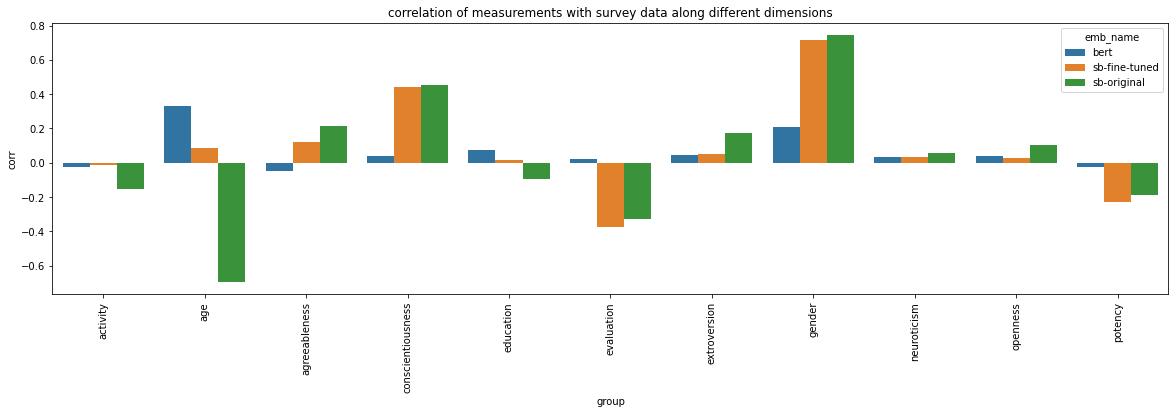

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns


corr_df = joined_df.groupby(['group', 'emb_name', 'func'])[['value', 'consensus']].corr().unstack()
corr_df.columns = ['vv', 'corr', 'cv', 'cc']
corr_df = corr_df.reset_index().drop(columns=['vv', 'cv', 'cc'])

def visualize_correlations(df, func):
    res = df[(df.func == func)]
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(x="group", y="corr", hue="emb_name", data=res)
    plt.xticks(rotation=90)
    plt.title(f"correlation of measurements with survey data along different dimensions")
    plt.show()
        

visualize_correlations(corr_df, 'ripa_kozlowski_fun')

# visualize results

In [120]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

        
selected_identities = [
    'adult', 'american', 'arab', 'asian', 'banker', 'black', 'boss', 'boy',
    'brother', 'bully', 'child', 'coach', 'conservative', 'consultant', 'cop',
    'criminal', 'daughter', 'democrat', 'dentist', 'doctor', 'executive',
    'father', 'girl', 'goon', 'guy', 'hispanic', 'idiot', 'intern', 'jerk',
    'judge', 'kid', 'lady', 'lawyer', 'liberal', 'man', 'minor', 'mother',
    'nurse', 'patient', 'physician', 'police_officer', 'politician',
    'principal', 'punk', 'republican', 'scientist', 'secretary', 'senator',
    'sister', 'son', 'surgeon', 'teenager', 'thug', 'toddler', 'white',
    'witness', 'woman'
]

selected_identities = [s for s in selected_identities if s in all_vocab]
selected_identities = [
    'maga', 'blm', 'build the wall', 'anti vaccine', 'get vaccinated', 'immigration activist',
    'pro abortion', 'democrat', 'republican'
]


## frequency of identities in corpus

In [121]:
import pickle 

with open('/user/smadani/navid/data/pis2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    
freq = {w: 0 for w in selected_identities}
for bio in tqdm(bios):
    for pi in bio:
        if pi in freq:
            freq[pi] += 1


100%|██████████| 15459872/15459872 [00:08<00:00, 1774206.55it/s]


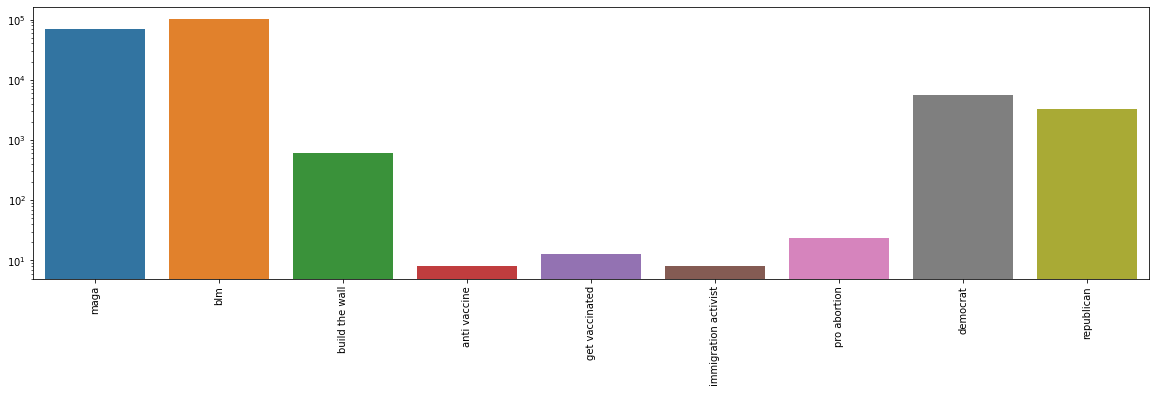

In [123]:
plt.figure(figsize=(20, 5))
sns.barplot(x=list(freq.keys()), y=list(freq.values()))
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

## value per measure category

In [124]:
def visualize_measure(measure_group, identities, function_name, measure_df):
    df = measure_df[(measure_df['identity'].isin(identities))
                    & (measure_df['group'] == measure_group)
                    & (measure_df['func'] == function_name)]
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(x="identity", y="value", hue="emb_name", data=df)
    plt.xticks(rotation=90)
    plt.title(measure_group)
    plt.show()

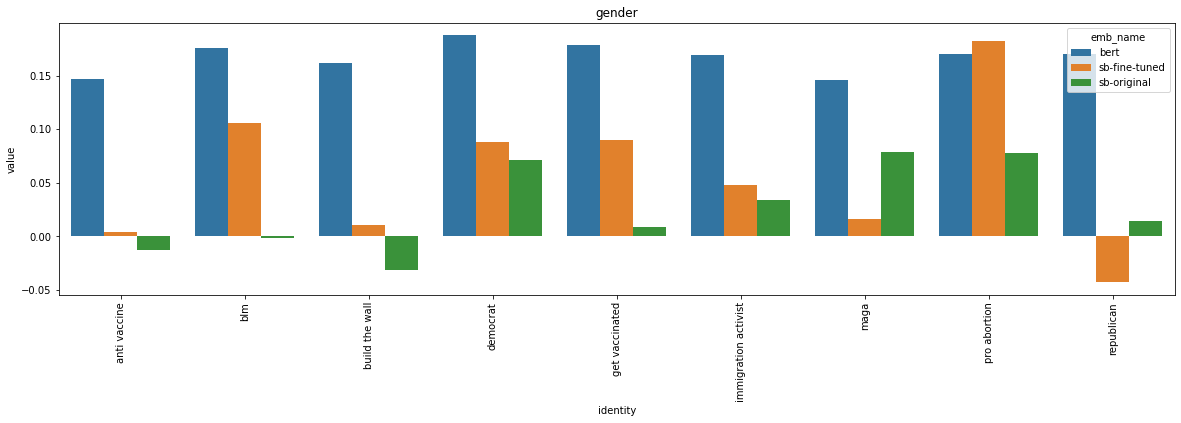

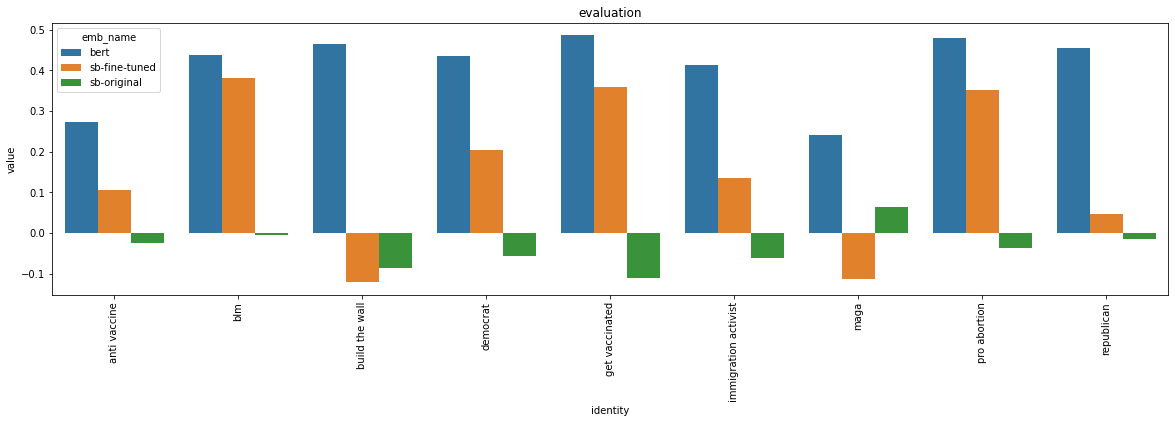

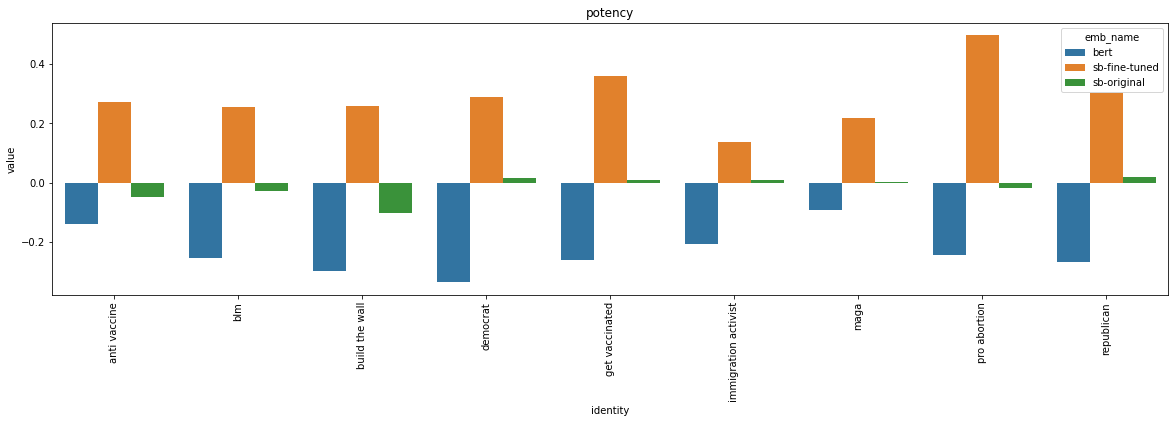

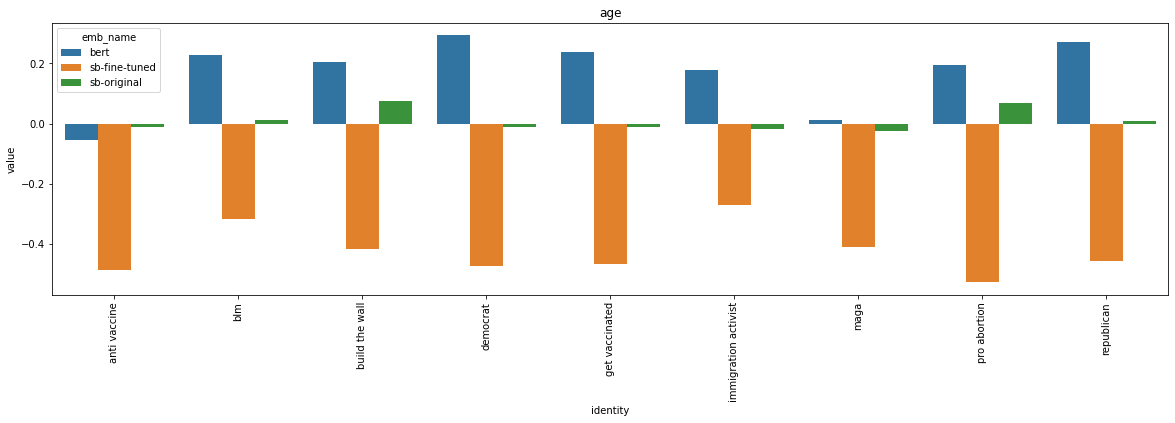

In [125]:
function_name = 'kozlowski_fun'
visualize_measure('gender', selected_identities, function_name, res_df)
visualize_measure('evaluation', selected_identities, function_name, res_df)
visualize_measure('potency', selected_identities, function_name, res_df)
visualize_measure('age', selected_identities, function_name, res_df)

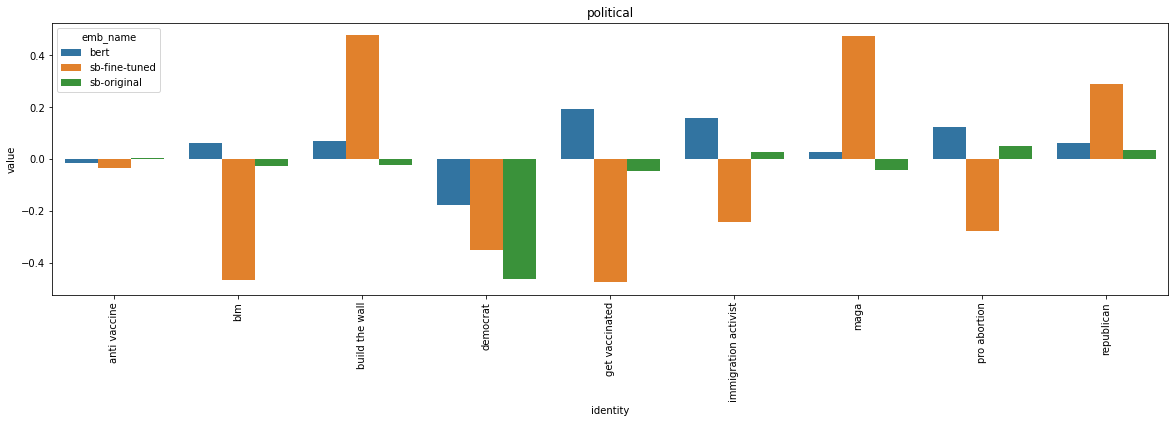

In [130]:
visualize_measure('political', selected_identities, function_name, res_df)

## most frequent neighbor phrases for each PI

In [ ]:
selected_identities = [
    'maga', 'blm', 'build the wall', 'anti vaccine', 'get vaccinated', 'immigration activist',
    'pro abortion', 'democrat', 'republican'
]

In [126]:
from collections import Counter

freq = {w: Counter() for w in selected_identities}
for bio in tqdm(bios):
    for pi in bio:
        if pi in freq:
            freq[pi].update(bio)


100%|██████████| 15459872/15459872 [00:07<00:00, 2170466.14it/s]


In [128]:
for pi in freq:
    print("*"*100)
    print(f"{pi}:")
    print("*"*100)
    print(freq[pi].most_common(20))

****************************************************************************************************
maga:
****************************************************************************************************
[('maga', 71175), ('kag', 19974), ('trump2020', 14819), ('wwg1wga', 12316), ('patriot', 8690), ('2a', 8111), ('conservative', 7343), ('christian', 5465), ('trump', 5308), ('nra', 4688), ('qanon', 3632), ('prolife', 3109), ('god', 3090), ('family', 3016), ('1a', 2768), ('wife', 2624), ('buildthewall', 2571), ('q', 2361), ('kag2020', 2349), ('draintheswamp', 2335)]
****************************************************************************************************
blm:
****************************************************************************************************
[('blm', 103918), ('she', 16535), ('her', 14141), ('acab', 12662), ('he', 7666), ('him', 6130), ('they', 5628), ('resist', 4408), ('them', 2470), ('18', 1825), ('fbr', 1803), ('lgbtq', 1684), ('21', 1480), ('artist', 14